In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Augmentation

In 2012 ImageNet competition, Alexnet successfully used data augmentation to effectively increase the size of the training data by a factor 2048. 

Data augmentation allows us to build more robust models by forcing the model to learn variance in the input space at the cost of increase data loading compute time.

In [2]:
#export
from exp.nb_11 import *

## PIL Transforms

Wer're going to start out by utilizing some of the core functions of the Python Image Library (PIL). 

<a href="http://effbot.org/imagingbook/image.htm">PIL Image Module docs </a>

In [3]:
#export
make_rgb._order = 0

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160) # downloads and returns a path to folder
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor] # transforms to be applied to images

In [5]:
def get_il(tfms): 
    return ImageList.from_files(path, tfms=tfms) # Imagelist from files

In [6]:
il = get_il(tfms)

The image without transforms:

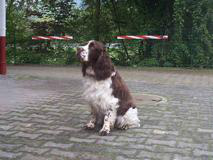

In [7]:
img = PIL.Image.open(il.items[1105]); img

The image with transforms:

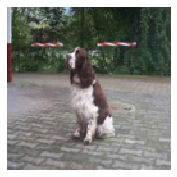

In [8]:
show_image(il[1105])

PIL's `getpixel`:

    Returns the pixel at the given position. If the image is a multi-layer image, this method returns a tuple.

In [9]:
img.getpixel((1,1))

(152, 160, 179)

In [10]:
import numpy as np

We'll be working with a lot of images so we'll want to make sure we are efficiently loading and augmenting them for training. 

In [11]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[0]))

641 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


When we resize an image we have different algorithms available to determine how the shuffling of pixels is done. 

These are the filter arguments passed to resize: 

- __NEAREST__ use nearest neighbour 
- __BILINEAR__ linear interpolation in a 2x2 environment 
- __BICUBIC__ cubic spline interpolation in a 4x4 environment 
- __ANTIALIAS__ a high-quality downsampling filter

Default or if the image has mode “1” or “P”, it is set to NEAREST.

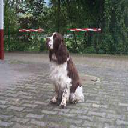

In [12]:
img.resize((128,128), resample=PIL.Image.NEAREST)

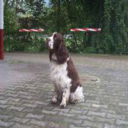

In [13]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

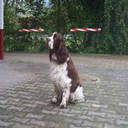

In [14]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

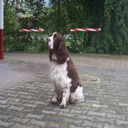

In [15]:
img.resize((128,128), resample=PIL.Image.BICUBIC)

A combination:

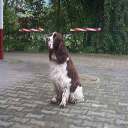

In [16]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

Timing the different resampling methods:

In [17]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.BICUBIC)

481 µs ± 4.27 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.BILINEAR)

360 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit -n 10 img.resize((224,224), resample=PIL.Image.NEAREST)

31.2 µs ± 5.25 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In terms of speed Nearest Neighbors is clearly the fastest on the CPU:

### Flip

Flipping can be done with PIL's `transpose`:

`im.transpose(method)` ⇒ image

    Returns a flipped or rotated copy of an image.

Method can be one of the following: 
- FLIP_LEFT_RIGHT == 0
- FLIP_TOP_BOTTOM == 1
- ROTATE_90
- ROTATE_180 
- ROTATE_270

In [20]:
PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.FLIP_TOP_BOTTOM

(0, 1)

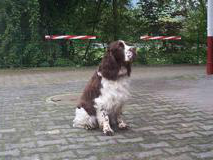

In [21]:
img.transpose(PIL.Image.FLIP_LEFT_RIGHT)

In [22]:
#export
import random

In [23]:
random.random()

0.6290836225707924

In [24]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()>.5 else x

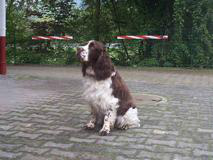

In [25]:
pil_random_flip(img)

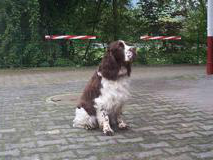

In [26]:
pil_random_flip(img)

Now we want to experiment with augmenting batches of images at a time. Let's do this by getting a batch of 64 copies of 1 image:

In [27]:
il1 = get_il(tfms)
il1.items = [il1.items[121]] * 64
dl = DataLoader(il1, 8)

In [28]:
x = next(iter(dl))

In [29]:
x.shape

torch.Size([8, 3, 128, 128])

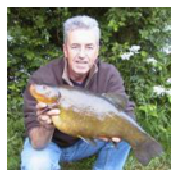

In [30]:
show_image(x[0])

Functions to view a batch:

In [31]:
#export 
def show_image(img, ax=None, figsize=(3,3)):
    if ax is None: fig, ax = plt.subplots(1,1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img.permute(1,2,0))
    

def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3, r*3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for img, ax in zip(x, axes.flat):
        show_image(img, ax)

Here is our batch displayed here with no data augmentation:

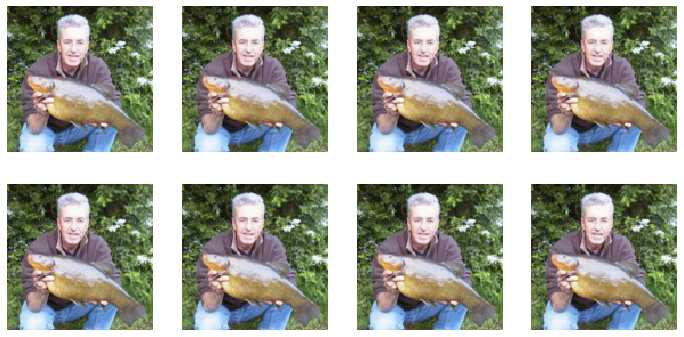

In [32]:
show_batch(x)

And now with data augmentation.

What is important to notice is how we built our transforms into our dataloader. When the `__getitem__` is called on the dataloader it applies whatever transforms it is given. 

This is a downstream effect of good software engineering.

In [33]:
il1.tfms.append(pil_random_flip)

In [34]:
x = next(iter(dl))

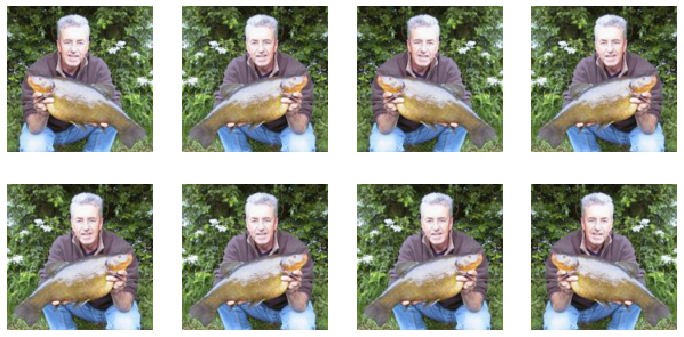

In [35]:
show_batch(x)

If we wanted to make it easier to set our parameter `p` that controls the probability of the image being flipped we can create a image flip class:

In [36]:
#export
class PilTransform(Transform): _order =11

class PilRandomFlip(PilTransform):
    def __init__(self,p = 0.5):
        self.p = float(p)
    
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random()<self.p else x

In [37]:
del(il1.tfms[-1])

In [38]:
il1.tfms.append(PilRandomFlip())

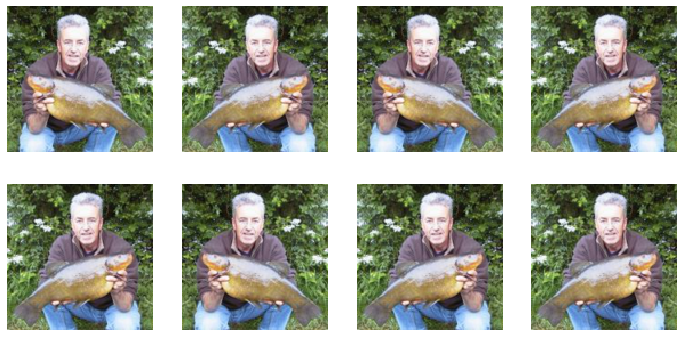

In [39]:
x = next(iter(dl))
show_batch(x)

In [40]:
PIL.Image.FLIP_LEFT_RIGHT,PIL.Image.ROTATE_270,PIL.Image.TRANSVERSE

(0, 4, 6)

We can easily iterate through our batch and apply differnt transpose positions:

In [41]:
img = PIL.Image.open(il.items[2000])

In [42]:
img = img.resize((128, 128), PIL.Image.NEAREST)

Note: `figsize` = width, height in inches. If not provided, defaults to rcParams["figure.figsize"] (default: [6.4, 4.8]) = [6.4, 4.8].

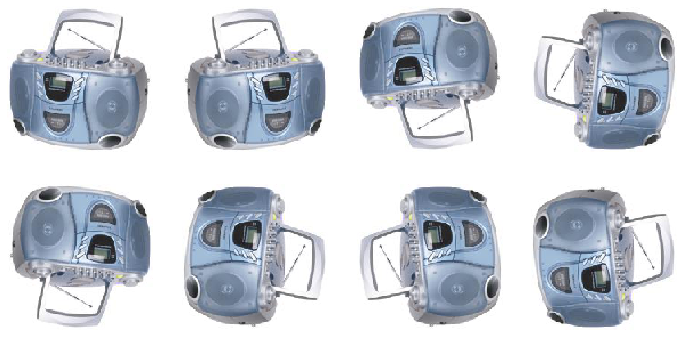

In [43]:
fig, axes = plt.subplots(2,4, figsize=(12,6))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i==0: ax.imshow(img)
    else: ax.imshow(img.transpose(i-1))

As a class:

In [44]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75):
        self.p = p * 7/8
        
    def __call__(self, x):
        if random.random() > self.p: return x
        else: return x.transpose(random.randint(0,6))

In [45]:
il1.tfms.append(PilRandomDihedral())

In [46]:
x = next(iter(dl))

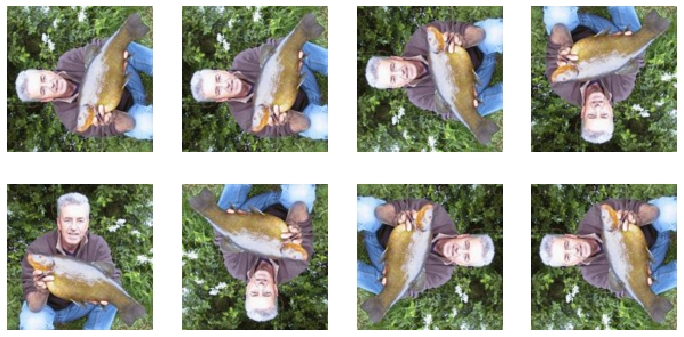

In [47]:
show_batch(x)

### Random Crop

In [48]:
img = PIL.Image.open(il.items[0])

In [49]:
img.size

(213, 160)

`im.crop(box)` ⇒ image

    Returns a copy of a rectangular region from the current image. The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate.

    This is a lazy operation. Changes to the source image may or may not be reflected in the cropped image. To get a separate copy, call the load method on the cropped copy.

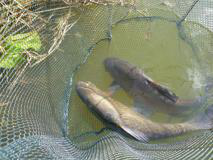

In [50]:
img

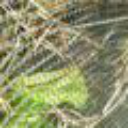

In [51]:
img.crop(box=(0,0,60,60)).resize((128,128), resample=PIL.Image.BILINEAR)

In [52]:
cnr2 = (0,0,60,60)
resample = PIL.Image.BILINEAR

In [53]:
%timeit -n 100 img.crop(cnr2).resize((128,128), resample=resample)

112 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We can use the `transform` method to combine crop and resize but it takes longer on average than chaining the above methods:

In [54]:
PIL.Image.EXTENT

1

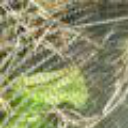

In [55]:
img.transform((128,128), PIL.Image.EXTENT, cnr2,resample=resample)

In [56]:
%timeit -n 100 img.transform((128,128), PIL.Image.EXTENT, cnr2,resample=resample)

346 µs ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
#export
from random import randint

Let's make a `GeneralCrop` class that inherits from `PilTransform`.

It will take a size, crop_size, and resample method.

In [58]:
#export
def _process_size(size):
    sz = listify(size)
    return tuple(sz if len(sz)==2 else [sz[0], sz[0]])

def _default_crop_size(w,h):
    return [w,w] if w < h else [h,h]


class GeneralCrop(PilTransform):
    
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample = resample
        self.size = _process_size(size)
        self.crop_size = None if crop_size is None else _process_size(crop_size)
    
    def default_crop_size(self, w, h): 
        return _default_crop_size(w, h)
    
    def __call__(self, x):
        crop_sz = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *crop_sz), resample=self.resample)
    
    def get_corners(self, w1,w2, h1, h2):
        return (0,0,w1,h1)

In [59]:
_process_size(128)

(128, 128)

In [60]:
_default_crop_size(128, 256)

[128, 128]

In [61]:
gc = GeneralCrop(128, crop_size=64)

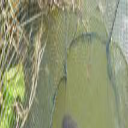

In [62]:
gc(img)

In [63]:
#export
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w,h): return [w/self.scale,h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w-wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [64]:
il1.tfms = [make_rgb, CenterCrop(64), to_byte_tensor, to_float_tensor]

Full image:

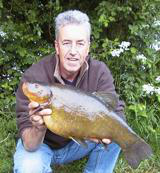

In [65]:
PIL.Image.open(il1.items[0])

Resized and cropped image:

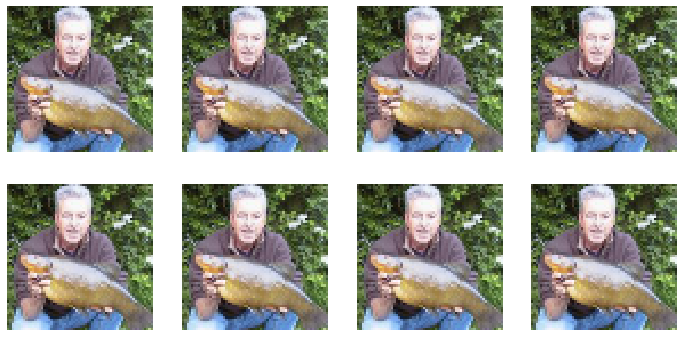

In [66]:
show_batch(next(iter(dl)))

### RandomResizeCrop

Data augmentation used on ImageNet (introduced [here](https://arxiv.org/pdf/1409.4842.pdf)) that consists of selecting 8 to 100% of the image area and a scale between 3/4 and 4/3 as a crop, then resizing it to the desired size. 

It combines some zoom and a bit of squishing at a very low computational cost.

In [67]:
random.uniform(1,4)

1.9965758721724685

In [68]:
# export
class RandomResizedCrop(GeneralCrop):
    def __init__(self, size, scale=(0.08,1.0), ratio=(3./4., 4./3.), resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        self.ratio = ratio
        
    
    def get_corners(self, w, h, wc, hc):
        # find random pixel values to crop the image
        area = w*h
        # 10 attempts
        for attempt in range(10):
            area = random.uniform(*self.scale) * area
            ratio = math.exp(random.uniform(math.log(self.ratio[0]), math.log(self.ratio[1])))
            new_w = int(round(math.sqrt(area * ratio)))
            new_h = int(round(math.sqrt(area / ratio)))
            if new_w <= w and new_h <= h:
                left = random.randint(0, w - new_w)
                top  = random.randint(0, h - new_h)
                return (left, top, left + new_w, top + new_h)
        
        # Fallback to squish
        if   w/h < self.ratio[0]: size = (w, int(w/self.ratio[0]))
        elif w/h > self.ratio[1]: size = (int(h*self.ratio[1]), h)
        else:                     size = (w, h)
        return ((w-size[0])//2, (h-size[1])//2, (w+size[0])//2, (h+size[1])//2)

In [69]:
il1.tfms = [make_rgb, RandomResizedCrop(128), to_byte_tensor, to_float_tensor]

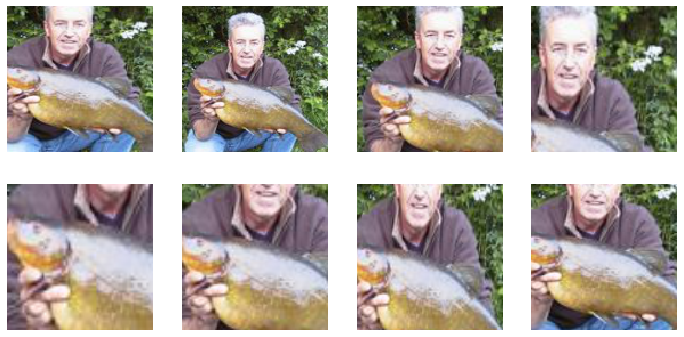

In [70]:
show_batch(next(iter(dl)))

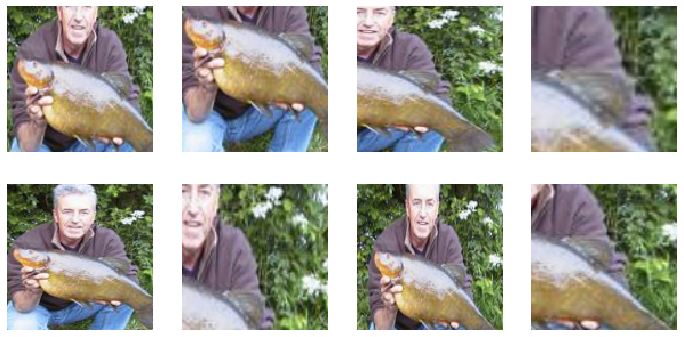

In [71]:
show_batch(next(iter(dl)))

### Perspective Warping

In [72]:
# export
from torch import FloatTensor,LongTensor

def find_coeffs(orig_pts, targ_pts):
    matrix = []
    #The equations we'll need to solve.
    for p1, p2 in zip(targ_pts, orig_pts):
        matrix.append([p1[0], p1[1], 1, 0, 0, 0, -p2[0]*p1[0], -p2[0]*p1[1]])
        matrix.append([0, 0, 0, p1[0], p1[1], 1, -p2[1]*p1[0], -p2[1]*p1[1]])

    A = FloatTensor(matrix)
    B = FloatTensor(orig_pts).view(8, 1)
    #The 8 scalars we seek are solution of AX = B
    return list(torch.solve(B,A)[0][:,0])

In [73]:
# export
def warp(img, size, src_coords, resample=PIL.Image.BILINEAR):
    w,h = size
    targ_coords = ((0,0),(0,h),(w,h),(w,0))
    c = find_coeffs(src_coords,targ_coords)
    res = img.transform(size, PIL.Image.PERSPECTIVE, list(c), resample=resample)
    return res

In [74]:
targ = ((0,0),(0,128),(128,128),(128,0))
src  = ((90,60),(30,280),(310,280),(250,60))

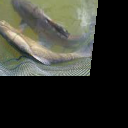

In [75]:
c = find_coeffs(src, targ)
img.transform((128,128), PIL.Image.PERSPECTIVE, list(c), resample=resample)

In [76]:
%timeit -n 10 warp(img, (128,128), src)

354 µs ± 8.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [77]:
%timeit -n 10 warp(img, (128,128), src, resample=PIL.Image.NEAREST)

188 µs ± 6.85 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


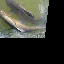

In [78]:
warp(img, (64,64), src, resample=PIL.Image.BICUBIC)

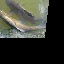

In [79]:
warp(img, (64,64), src, resample=PIL.Image.NEAREST)

In [80]:
# export
def uniform(a,b): return a + (b-a) * random.random()

In [81]:
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.NEAREST): 
        self.resample,self.size,self.magnitude = resample,_process_size(size),magnitude
        self.crop_size = None if crop_size is None else _process_size(crop_size)
        
    def __call__(self, x):
        csize = _default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        up_t,lr_t = uniform(-self.magnitude, self.magnitude),uniform(-self.magnitude, self.magnitude)
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [82]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.1), to_byte_tensor, to_float_tensor]

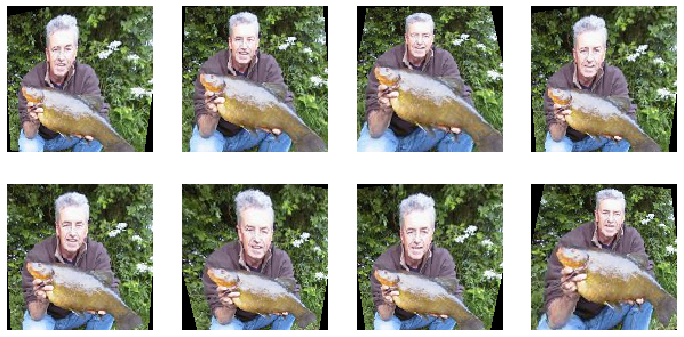

In [83]:
x = next(iter(dl))
show_batch(x)

In [84]:
# export
class PilTiltRandomCrop(PilTransform):
    def __init__(self, size, crop_size=None, magnitude=0., resample=PIL.Image.BILINEAR): 
        self.resample,self.size,self.magnitude = resample, _process_size(size),magnitude
        self.crop_size = None if crop_size is None else _process_size(crop_size)
        
    def __call__(self, x):
        csize = _default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        left,top = randint(0,x.size[0]-csize[0]),randint(0,x.size[1]-csize[1])
        top_magn = min(self.magnitude, left/csize[0], (x.size[0]-left)/csize[0]-1)
        lr_magn  = min(self.magnitude, top /csize[1], (x.size[1]-top) /csize[1]-1)
        up_t,lr_t = uniform(-top_magn, top_magn),uniform(-lr_magn, lr_magn)
        src_corners = tensor([[-up_t, -lr_t], [up_t, 1+lr_t], [1-up_t, 1-lr_t], [1+up_t, lr_t]])
        src_corners = src_corners * tensor(csize).float() + tensor([left,top]).float()
        src_corners = tuple([(int(o[0].item()), int(o[1].item())) for o in src_corners])
        return warp(x, self.size, src_corners, resample=self.resample)

In [85]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, 100, magnitude=0.2), to_byte_tensor, to_float_tensor]

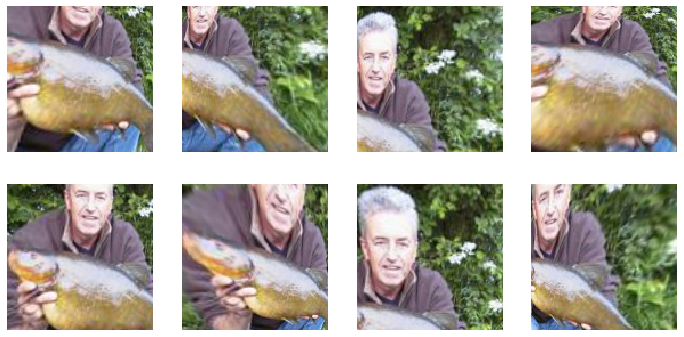

In [86]:
x = next(iter(dl))
show_batch(x)

### Faster Tensor Creation

In [87]:
[(o._order,o) for o in sorted(tfms, key=operator.attrgetter('_order'))]

[(0, <function exp.nb_09.make_rgb(x)>),
 (10, <exp.nb_09.ResizeFixed at 0x20abf988460>),
 (11, <__main__.PilRandomFlip at 0x20a8c87e8b0>),
 (11, <__main__.PilRandomDihedral at 0x20a8b0348e0>),
 (20, <function exp.nb_09.to_byte_tensor(item)>),
 (30, <function exp.nb_09.to_float_tensor(item)>)]

In [88]:
#export
import numpy as np

def np_to_float(x): return torch.from_numpy(np.array(x, dtype=np.float32, copy=False)).permute(2,0,1).contiguous()/255.
np_to_float._order = 30

In [89]:
%timeit -n 10 to_float_tensor(to_byte_tensor(img))

107 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
%timeit -n 10 np_to_float(img)

144 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Batch Data Augmentation

Once we have resized our images so that we can batch them together, we can apply more data augmentation on a batch level. For the affine/coord transforms, we proceed like this:
1. generate a grid map of the size of our batch (bs x height x width x 2) that contains the coordinates of a grid of size height x width (this will be the final size of the image, and doesn't have to be the same as the current size in the batch)
2. apply the affine transforms (which is a matrix multiplication) and the coord transforms to that grid map
3. interpolate the values of the final pixels we want from the initial images in the batch, according to the transformed grid map

For 1. and 3. there are PyTorch functions: `F.affine_grid` and `F.grid_sample`. `F.affine_grid` can even combine 1 and 2 if we just want to do an affine transformation.

###  Step 1: Generate the Grid

In [91]:
il1.tfms = [make_rgb, PilTiltRandomCrop(128, magnitude=0.2), to_byte_tensor, to_float_tensor]

In [92]:
dl = DataLoader(il1, 64)

In [93]:
x = next(iter(dl))

In [94]:
from torch import FloatTensor

def affine_grid_cpu(size):
    N, C, H, W = size
    grid = FloatTensor(N, H, W, 2)
    linear_points = torch.linspace(-1, 1, W) if W > 1 else tensor([-1])
    grid[:, :, :, 0] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, :, 0])
    linear_points = torch.linspace(-1, 1, H) if H > 1 else tensor([-1])
    grid[:, :, :, 1] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, :, 1])
    return grid

In [95]:
grid = affine_grid_cpu(x.size())

In [96]:
grid.shape

torch.Size([64, 128, 128, 2])

In [97]:
grid[0,:5,:5]

tensor([[[-1.0000, -1.0000],
         [-0.9843, -1.0000],
         [-0.9685, -1.0000],
         [-0.9528, -1.0000],
         [-0.9370, -1.0000]],

        [[-1.0000, -0.9843],
         [-0.9843, -0.9843],
         [-0.9685, -0.9843],
         [-0.9528, -0.9843],
         [-0.9370, -0.9843]],

        [[-1.0000, -0.9685],
         [-0.9843, -0.9685],
         [-0.9685, -0.9685],
         [-0.9528, -0.9685],
         [-0.9370, -0.9685]],

        [[-1.0000, -0.9528],
         [-0.9843, -0.9528],
         [-0.9685, -0.9528],
         [-0.9528, -0.9528],
         [-0.9370, -0.9528]],

        [[-1.0000, -0.9370],
         [-0.9843, -0.9370],
         [-0.9685, -0.9370],
         [-0.9528, -0.9370],
         [-0.9370, -0.9370]]])

In [98]:
%timeit -n 10 grid = affine_grid_cpu(x.size())

2.18 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Coords in the grid go from -1, to 1 (PyTorch convention).

PyTorch version is slower on the CPU but optimized to go very fast on the GPU

In [99]:
m = tensor([[1., 0., 0.], [0., 1., 0.]])

In [100]:
theta = m.expand(x.size(0), 2, 3)

In [101]:
theta.shape

torch.Size([64, 2, 3])

In [102]:
%timeit -n 10 grid = F.affine_grid(theta, x.size())

C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


6.37 ms ± 600 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
%timeit -n 10 grid = F.affine_grid(theta.cuda(), x.size())

The slowest run took 29.83 times longer than the fastest. This could mean that an intermediate result is being cached.
4.77 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So we write our own version that dispatches on the CPU with our function and uses PyTorch's on the GPU.

In [104]:
def affine_grid(x, size):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    if x.device.type == 'cpu': return affine_grid_cpu(size) 
    m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)
    return F.affine_grid(m.expand(x.size(0), 2, 3), size)

In [105]:
grid = affine_grid(x, 128)

### Step 2: Affine Multiplication

In 2D an affine transformation has the form y = Ax + b where A is a 2x2 matrix and b a vector with 2 coordinates. It's usually represented by the 3x3 matrix
```
A[0,0]  A[0,1]  b[0]
A[1,0]  A[1,1]  b[1]
   0       0     1
```
because then the composition of two affine transforms can be computed with the matrix product of their 3x3 representations.

In [106]:
from torch import stack,zeros_like,ones_like

In [107]:
def rotation_matrix(thetas):
    thetas.mul_(math.pi/180)
    rows = [stack([thetas.cos(),             thetas.sin(),             torch.zeros_like(thetas)], dim=1),
            stack([-thetas.sin(),            thetas.cos(),             torch.zeros_like(thetas)], dim=1),
            stack([torch.zeros_like(thetas), torch.zeros_like(thetas), torch.ones_like(thetas)], dim=1)]
    return stack(rows, dim=1)

In [108]:
thetas = torch.empty(x.size(0)).uniform_(-30,30)

In [109]:
thetas[:5]

tensor([ 12.1455, -23.8322,  28.5988, -28.1824,   3.5985])

In [110]:
m = rotation_matrix(thetas)

In [111]:
m.shape, m[:,None].shape, grid.shape

(torch.Size([64, 3, 3]),
 torch.Size([64, 1, 3, 3]),
 torch.Size([64, 128, 128, 2]))

In [112]:
grid.view(64,-1,2).shape

torch.Size([64, 16384, 2])

We have to apply our rotation to every point in the grid. The matrix a is given by the first two rows and two columns of `m` and the vector `b` is the first two coefficients of the last column. Of course we have to deal with the fact that here `m` is  a batch of matrices.

In [113]:
a = m[:,:2,:2]
b = m[:, 2:,:2]
tfm_grid = (grid.view(64,-1,2) @ a + b).view(64, 128, 128, 2)

We can also do this without the `view` by using broadcasting. 

In [114]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

6.34 ms ± 708 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [115]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

5.19 ms ± 389 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [116]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

6.08 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

4.67 ms ± 379 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And on the GPU

In [118]:
grid = grid.cuda()
m = m.cuda()

In [119]:
%timeit -n 10 tfm_grid = grid @ m[:,None,:2,:2] + m[:,2,:2][:,None,None]

219 µs ± 52.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
%timeit -n 10 tfm_grid = torch.einsum('bijk,bkl->bijl', grid, m[:,:2,:2]) + m[:,2,:2][:,None,None]

212 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
%timeit -n 10 tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2][:,None,None]

199 µs ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [122]:
%timeit -n 10 tfm_grid = (torch.bmm(grid.view(64,-1,2), m[:,:2,:2]) + m[:,2,:2][:,None]).view(-1, 128, 128, 2)

125 µs ± 5.56 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Step 3: Interpolate

In [123]:
tfm_grid = torch.bmm(grid.view(64,-1,2), m[:,:2,:2]).view(-1, 128, 128, 2)

In [124]:
tfm_x = F.grid_sample(x, tfm_grid.cpu())

C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


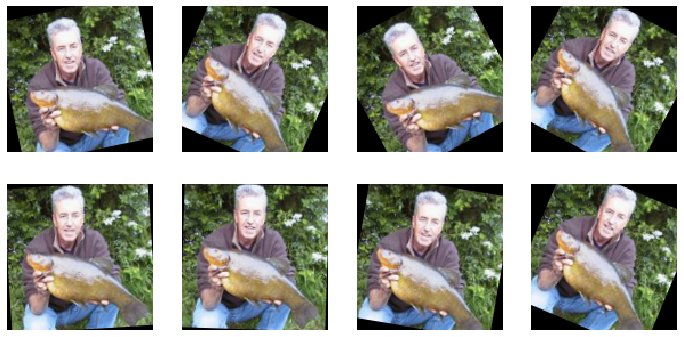

In [125]:
show_batch(tfm_x, r=2)

In [126]:
tfm_x = F.grid_sample(x, tfm_grid.cpu(), padding_mode='reflection')

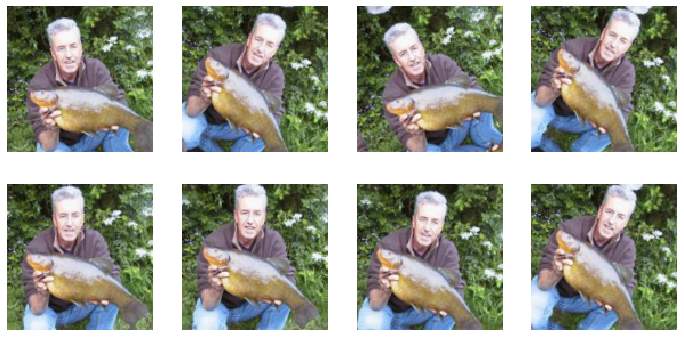

In [127]:
show_batch(tfm_x, r=2)

### Timing

In [128]:
def rotate_batch(x, size, degrees):
    grid = affine_grid(x, size)
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = grid @ m[:,:2,:2].unsqueeze(1) + m[:,2,:2][:,None,None]
    return F.grid_sample(x, tfm_grid)

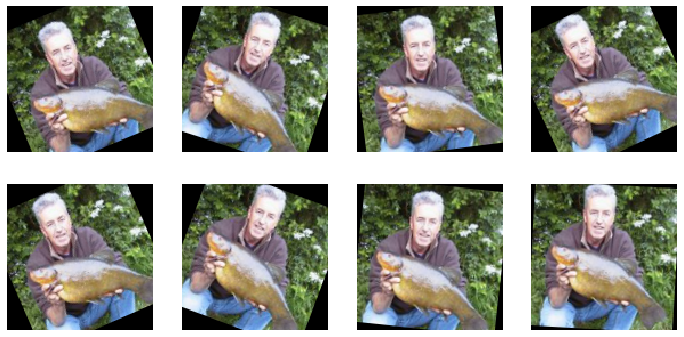

In [129]:
show_batch(rotate_batch(x, 128, 30), r=2)

In [130]:
%timeit -n 10 tfm_x = rotate_batch(x, 128, 30)

15.7 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

5.09 ms ± 316 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Not bad for 64 rotations!

### Jit Version

But we can be even faster!

In [132]:
from torch import Tensor

from torch.jit import script

In [133]:
@script
def rotate_batch(x:Tensor, size:int, degrees:float) -> Tensor:
    sz = (x.size(0),x.size(1)) + (size,size)
    idm = torch.zeros(2,3, device=x.device)
    idm[0,0] = 1.
    idm[1,1] = 1.
    grid = F.affine_grid(idm.expand(x.size(0), 2, 3), sz)
    thetas = torch.zeros(x.size(0), device=x.device).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    tfm_grid = torch.matmul(grid, m[:,:2,:2].unsqueeze(1)) + m[:,2,:2].unsqueeze(1).unsqueeze(2)
    return F.grid_sample(x, tfm_grid)

In [134]:
m = tensor([[1., 0., 0.], [0., 1., 0.]], device=x.device)

In [135]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old b

The slowest run took 4.27 times longer than the fastest. This could mean that an intermediate result is being cached.
6.12 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\palme\Anaconda3\envs\dl_nbs\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old b

The speed of this depends a lot on what card you have. On a V100 it is generally about 3x faster than non-JIT (as at April 2019) although PyTorch JIT is rapidly improving.

### Affine multiplication with `affine`

In [136]:
def rotate_batch(x, size, degrees):
    size = (size,size) if isinstance(size, int) else tuple(size)
    size = (x.size(0),x.size(1)) + size
    thetas = x.new(x.size(0)).uniform_(-degrees,degrees)
    m = rotation_matrix(thetas)
    grid = F.affine_grid(m[:,:2], size)
    return F.grid_sample(x.cuda(), grid)

In [137]:
%timeit -n 10 tfm_x = rotate_batch(x.cuda(), 128, 30)

3.47 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
nb_auto_export()